# k-means clustering, Gaussian Mixture Models (GMM)


This notebook demonstrates k-means clustering using `scikit-learn` and also discusses expectation-maximization algorithm and how it is connected to the concept of **G**aussian **M**ixture **M**odel (GMM).

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

- The _"cluster center"_ is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #Plot styling
import numpy as np

### Create synthetic dataset of unlablled blobs

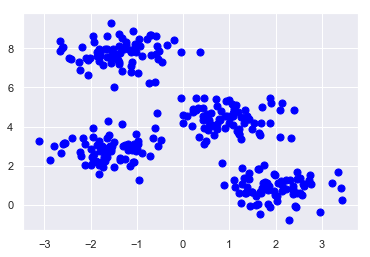

In [6]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50,color='blue');

### Import `KMeans` class from Scikit-learn and fit the data
Note, here we are not doing a test/train split as it is unsupervised machine learning technique.

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

### Visualize the fitted data by coloring the blobs by assigned label numbers
We will use the `c` argument in the `plt.scatter()` function.

We will also try to make the cluster centers prominent.

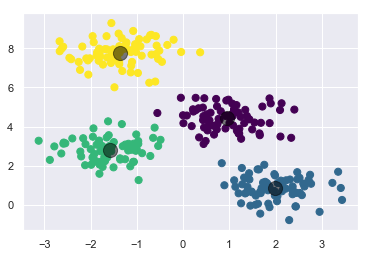

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [9]:
from IPython.display import HTML
HTML('<iframe width="550" height="450" src="https://www.youtube.com/embed/5I3Ei69I40s" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

### How k-means is a special case of Expectation-maximization (EM) algorithm

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and special case of this more general algorithm. The basic algorithmic flow of k-means is to,

- Guess some cluster center (initialization)
- Repeat following steps untill converged,
    - _E-step_: assign points to the nearest cluster center
    - _M-Step_: set the cluster centers to the mean

Here the "E-step" or "Expectation step" involves updating our expectation of which cluster each point belongs to. 

The "M-step" or "Maximization step" involves **maximizing some fitness function** that defines the location of the cluster centers. In the case of k-means, that maximization is accomplished by taking a simple mean of the data in each cluster.

### Implementing k-means from scratch

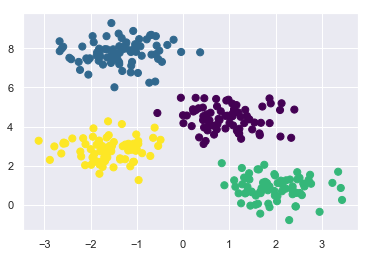

In [10]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Not optimally guaranteed and initialization
Under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics. However, it is best to note that, **although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution**.

The **initialization is important** and particularly bad initialization can sometimes lead to clearly sub-optimal clustering.

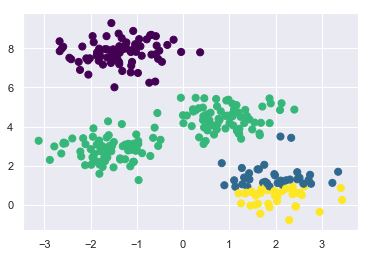

In [11]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Number of clusters?

A common challenge with k-means is that you must tell it how many clusters you expect. 
It cannot learn the number of clusters from the data.

If we force the k-means to look for 6 clusters instead of 4, it will come back with 6 but they may not be what we are looking for!

Some methods like **elbow** and **silhouette analysis** can be used to gauge a good number of clusters.

In [8]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Limitations - example
k-means algorithm will often be ineffective if the clusters have complicated geometries. In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries.

In [9]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

In [10]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Kernel transformations?

The situation above is reminiscent of the **Support Vector Machines**, where we use a **kernel transformation to project the data into a higher dimension** where a linear separation is possible. We might imagine using the same trick to allow k-means to discover non-linear boundaries.

One version of this kernelized k-means is implemented in Scikit-Learn within the `SpectralClustering` estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:


In [11]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

/Users/eli/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/eli/anaconda3/lib/python3.6/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


### Limitation of k-means

Simplicity of k-means is a big advantage for fast processing of large scale data. But this very simplicity also leads to practical challenges in its application. 

In particular, the non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.

Gaussian mixture models (GMMs), can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering.

In [12]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.7, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [14]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [15]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', edgecolor='k',zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [16]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

### k-means fails for non-circular blobs of data
There appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the **k-means model has no intrinsic measure of probability or uncertainty** of cluster assignments.

For k-means these cluster models must be circular. k-means has **no built-in way of accounting for oblong or elliptical clusters**. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled.

k-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. This results in a mixing of cluster assignments where the resulting circles overlap.

In [17]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

### Generalizing to Gaussian Mixture Models (GMM)

Two ideas may come to mind,
- You could measure uncertainty in cluster assignment by comparing the distances of each point to all cluster centers, rather than focusing on just the closest. 
- You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means.

However, because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the `predict_proba` method. This returns a matrix of size `[n_samples, n_clusters]` which measures the probability that any point belongs to the given cluster.

In [18]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [19]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.022 0.    0.978 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.999 0.001]
 [0.    0.    0.    1.   ]]


### Visualize uncertainty by making data point size proportional to probability

In [20]:
size = probs.max(1)/0.02  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, edgecolor='k', cmap='viridis', s=size);

In [21]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2,edgecolor='k')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2,cmap='viridis',edgecolor='k')
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [22]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

### GMM as density estimation and generative model algorithm

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

In [23]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1],edgecolor='k');

In [24]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plt.figure(figsize=(8,5))
plot_gmm(gmm2, Xmoon)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.

In [25]:
gmm4 = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
plot_gmm(gmm4, Xmoon, label=False)

In [26]:
gmm8 = GaussianMixture(n_components=8, covariance_type='full', random_state=0)
plot_gmm(gmm8, Xmoon, label=False)

In [27]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

In [28]:
Xnew,_ = gmm4.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1],edgecolor='k');

In [29]:
Xnew,_ = gmm8.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1],edgecolor='k');

In [30]:
Xnew,_ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1],edgecolor='k');

### This generative model works for any type of data shape

In [31]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50,color='blue',edgecolor='k');

In [32]:
gmm_gen = GaussianMixture(n_components=16, covariance_type='full', random_state=0,tol=1e-6,max_iter=1000,n_init=10)

In [33]:
gmm_gen.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
        means_init=None, n_components=16, n_init=10, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=1e-06, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [34]:
Xnew,_ = gmm_gen.sample(300)
plt.scatter(Xnew[:, 0], Xnew[:, 1],color='green',edgecolor='k');